# Train simple baseline models on merged seasons (full) data with historical rolling features and with data about next opponent team

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data.data_loader import load_master_team_list
from src.data.data_loader import load_understat_team_stats
from src.features.data_engineering import preprocess_seasons_data, reverse_processing, get_oponent_team_stats
from src.features.utils import idx_to_team_name, str_date_days_forward

In [2]:
rolling_columns = ['assists', 'bonus', 'bps', 'clean_sheets',
                   'creativity', 'goals_conceded', 'goals_scored',
                   'ict_index', 'influence', 'minutes',
                   'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
                   'saves', 'selected', 'player_team_score', 'opponent_team_score', 'threat',
                   'total_points', 'transfers_in', 'transfers_out',
                   'value', 'yellow_cards']

times = ['all', 6, 3]

In [3]:
from src.features.data_engineering import get_merged_seasons_data

data = get_merged_seasons_data()
data_processed = data.copy()

In [4]:
(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(rolling_features=True, rolling_columns=rolling_columns, rolling_times=times, opponent_team_stats=True)

## Train on baseline Dummy model

In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [9]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x_train, y_train)

DummyRegressor()

In [10]:
y_pred = dummy_regr.predict(x_test)

In [11]:
mean_squared_error(y_pred, y_test)

6.198001949957157

## Train on baseline decision tree model

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
tree_regr = DecisionTreeRegressor()
tree_regr.fit(x_train, y_train)

DecisionTreeRegressor()

In [14]:
y_pred = tree_regr.predict(x_test)

In [15]:
mean_squared_error(y_pred, y_test)

9.276862381062891

## Train on baseline SVR model

In [16]:
from sklearn.svm import LinearSVR

In [17]:
model_svr = LinearSVR()
model_svr.fit(x_train, y_train)

d:\studies\informatyka\semestr_3\fpl_ai_manager\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

In [18]:
# create series to keep indexes and name same as in the original y data
y_pred_svr = pd.Series(model_svr.predict(x_test), index=y_test.index, name='predicted_total_points_next_gameweek')

In [19]:
mean_squared_error(y_pred_svr, y_test)

5.060001693273523

## Merge results with footballers extracted target data

In [20]:
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)

In [21]:
predictions_svr = pd.concat([y_pred_svr, x_test_reversed], axis=1)

In [22]:
#preview predictions_svr sorted by predicted total points descending
predictions_svr.sort_values(by='predicted_total_points_next_gameweek', ascending=False).head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS,position_DEF,position_FWD,position_GK,position_MID
115301,3.848607,Mohamed Salah,1,233,3.0,2021-22,2.0,2.000000,2.000000,2.000000,...,1.690000,1.690000,0.110000,3.000000,7.000000,1.460000,0.0,0.0,0.0,1.0
120474,3.664789,Mohamed Salah,10,233,5.0,2021-22,1.0,1.000000,0.833333,0.700000,...,1.042857,1.042857,0.588571,5.714286,4.714286,1.878571,0.0,0.0,0.0,1.0
68824,3.652910,Raheem_Sterling_214,2,214,8.0,2019-20,0.0,0.000000,0.000000,0.000000,...,1.625000,1.625000,-0.520000,6.500000,9.000000,1.190000,0.0,0.0,0.0,1.0
68032,3.589415,Riyad_Mahrez_217,1,217,1.0,2019-20,3.0,3.000000,3.000000,3.000000,...,0.640000,0.640000,1.930000,15.000000,2.000000,2.590000,0.0,0.0,0.0,1.0
117091,3.525489,Sadio ManÃ©,4,230,8.0,2021-22,0.0,0.333333,0.250000,0.250000,...,0.855000,0.855000,0.327500,5.250000,8.000000,1.570000,0.0,0.0,0.0,1.0
55441,3.504597,Mohamed_Salah_253,18,253,12.0,2018-19,1.0,0.333333,0.333333,0.333333,...,1.597778,1.597778,-0.534444,4.333333,7.000000,0.984444,0.0,0.0,0.0,1.0
121953,3.500022,Mohamed Salah,12,233,6.0,2021-22,0.0,0.666667,0.833333,0.666667,...,1.092857,1.092857,0.174286,7.000000,6.285714,1.691429,0.0,0.0,0.0,1.0
8777,3.427472,Alexis_Sánchez,16,12,5.0,2016-17,0.0,0.666667,0.333333,0.375000,...,0.832500,0.832500,0.993750,12.875000,3.375000,2.106250,0.0,0.0,0.0,1.0
117086,3.410111,Mohamed Salah,4,233,12.0,2021-22,0.0,0.000000,0.500000,0.500000,...,0.855000,0.855000,0.327500,5.250000,8.000000,1.570000,0.0,0.0,0.0,1.0
115422,3.409724,Mohamed Salah,2,233,10.0,2021-22,0.0,1.000000,1.000000,1.000000,...,0.475000,0.475000,1.940000,16.500000,3.000000,2.550000,0.0,0.0,0.0,1.0


### Train baseline MLP model

In [23]:
import tensorflow as tf

In [24]:
model_mlp = tf.keras.models.Sequential()

model_mlp.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model_mlp.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_mlp.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_mlp.add(tf.keras.layers.Dense(units=126, activation='relu'))
model_mlp.add(tf.keras.layers.Dense(units=64, activation='relu'))
model_mlp.add(tf.keras.layers.Dense(units=1, activation='linear'))


In [25]:
model_mlp.compile(optimizer='adam',
                  loss='mse')

In [26]:
history = model_mlp.fit(x_train, y_train,
                        batch_size=16,
                        epochs=15,
                        validation_split=0.3)

Epoch 1/15
4525/4525 [==============================] - 7s 1ms/step - loss: 4.5823 - val_loss: 4.4256
Epoch 2/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4999 - val_loss: 4.5075
Epoch 3/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4748 - val_loss: 4.4034
Epoch 4/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4566 - val_loss: 4.3582
Epoch 5/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4463 - val_loss: 4.6861
Epoch 6/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4360 - val_loss: 4.4204
Epoch 7/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4253 - val_loss: 4.3332
Epoch 8/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4200 - val_loss: 4.5303
Epoch 9/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.4100 - val_loss: 4.5135
Epoch 10/15
4525/4525 [==============================] - 6s 1ms/step - loss: 4.402

In [28]:
score = model_mlp.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: 4.386831760406494


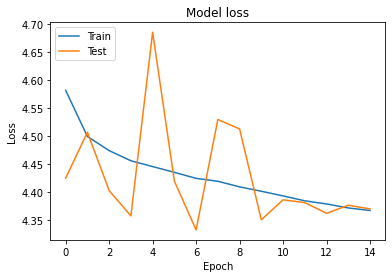

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
y_pred_mlp = pd.Series(model_mlp.predict(x_test).reshape(-1,), index=y_test.index, name='predicted_total_points_next_gameweek')

In [32]:
predictions_mlp = pd.concat([y_pred_mlp, x_test_reversed], axis=1)
#preview predictions_mlp sorted by predicted total points descending
predictions_mlp.sort_values(by='predicted_total_points_next_gameweek', ascending=False).head(1000)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS,position_DEF,position_FWD,position_GK,position_MID
69942,8.482849,Mohamed_Salah_191,4,191,9.0,2019-20,1.0,0.333333,0.500000,0.500000,...,1.397500,1.397500,-0.685000,3.500000,8.250000,0.790000,0.0,0.0,0.0,1.0
55441,8.000189,Mohamed_Salah_253,18,253,12.0,2018-19,1.0,0.333333,0.333333,0.333333,...,1.597778,1.597778,-0.534444,4.333333,7.000000,0.984444,0.0,0.0,0.0,1.0
81319,7.845495,Mohamed_Salah_191,24,191,14.0,2019-20,0.0,0.333333,0.166667,0.217391,...,1.953000,1.801000,-0.883000,4.900000,7.500000,0.785000,0.0,0.0,0.0,1.0
115301,7.770132,Mohamed Salah,1,233,3.0,2021-22,2.0,2.000000,2.000000,2.000000,...,1.690000,1.690000,0.110000,3.000000,7.000000,1.460000,0.0,0.0,0.0,1.0
117086,7.610651,Mohamed Salah,4,233,12.0,2021-22,0.0,0.000000,0.500000,0.500000,...,0.855000,0.855000,0.327500,5.250000,8.000000,1.570000,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,4.118396,Branislav_Ivanovic,1,76,2.0,2016-17,0.0,0.000000,0.000000,0.000000,...,0.940000,0.940000,-0.760000,4.000000,6.000000,0.590000,1.0,0.0,0.0,0.0
106575,4.118009,Kasper Schmeichel,26,217,2.0,2020-21,0.0,0.000000,0.000000,0.000000,...,0.893333,0.807778,0.715556,10.333333,6.555556,1.986667,0.0,0.0,1.0,0.0
94974,4.117443,Timo Werner,9,117,2.0,2020-21,1.0,0.333333,0.333333,0.333333,...,1.007143,0.790000,0.944286,4.285714,5.714286,1.984286,0.0,1.0,0.0,0.0
56546,4.117311,Kieran_Trippier_357,20,357,6.0,2018-19,0.0,0.333333,0.166667,0.250000,...,1.682000,1.530000,-0.518000,3.700000,8.000000,1.047000,1.0,0.0,0.0,0.0


## Train on baseline XGBoost model

In [33]:
import xgboost as xgb

In [34]:
model_xgb = xgb.XGBRegressor()

In [35]:
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [36]:
# create series to keep indexes and name same as in the original y data
y_pred_xgb = pd.Series(model_xgb.predict(x_test), index=y_test.index,
                        name='predicted_total_points_next_gameweek')

In [37]:
predictions_xgb = pd.concat([y_pred_xgb, x_test_reversed], axis=1)
#preview predictions_xgb sorted by predicted total points descending
predictions_xgb.sort_values(by='predicted_total_points_next_gameweek', ascending=False).head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS,position_DEF,position_FWD,position_GK,position_MID
91840,16.599508,Kevin De Bruyne,3,272,2.0,2020-21,0.0,0.500000,0.500000,0.500000,...,2.080000,1.320000,-0.510000,3.000000,11.333333,0.863333,0.0,0.0,0.0,1.0
115304,14.742012,Trent Alexander-Arnold,1,237,12.0,2021-22,0.0,0.000000,0.000000,0.000000,...,1.690000,1.690000,0.110000,3.000000,7.000000,1.460000,1.0,0.0,0.0,0.0
4162,11.817992,Joe_Allen,8,202,2.0,2016-17,0.0,0.000000,0.000000,0.000000,...,2.467143,2.031429,-1.404286,2.714286,12.857143,0.644286,0.0,0.0,0.0,1.0
5273,11.799948,Zlatan_Ibrahimovic,10,272,12.0,2016-17,0.0,0.000000,0.166667,0.100000,...,2.155000,1.900000,-0.598333,4.333333,12.833333,0.990000,0.0,1.0,0.0,0.0
92638,11.246256,Timo Werner,5,117,2.0,2020-21,1.0,0.333333,0.400000,0.400000,...,2.265000,1.695000,-0.825000,7.500000,6.250000,0.935000,0.0,1.0,0.0,0.0
74891,11.054451,Kevin_De Bruyne_215,13,215,10.0,2019-20,0.0,0.000000,0.166667,0.769231,...,1.882857,1.882857,-0.960000,2.714286,11.000000,0.751429,0.0,0.0,0.0,1.0
55288,10.953720,Eden_Hazard_122,17,122,2.0,2018-19,1.0,1.333333,0.833333,0.529412,...,1.180000,1.180000,-0.061111,3.666667,6.888889,1.493333,0.0,0.0,0.0,1.0
110640,10.623285,Matheus Pereira,32,481,10.0,2020-21,0.0,0.666667,0.333333,0.187500,...,1.461250,1.366250,-0.422500,5.625000,6.875000,0.958750,0.0,0.0,0.0,1.0
22988,10.622760,Harry_Kane,37,403,17.0,2016-17,1.0,0.333333,0.500000,0.189189,...,1.750000,1.560000,-0.537500,5.750000,6.250000,0.875000,0.0,1.0,0.0,0.0
48488,10.596080,David_Silva_271,5,271,0.0,2018-19,0.0,0.000000,0.000000,0.000000,...,1.688000,1.232000,-0.166000,4.200000,8.800000,0.970000,0.0,0.0,0.0,1.0


In [38]:
mean_squared_error(y_pred_xgb, y_test)

4.431977703906927

Feature 0: assists, Score: 0.0006900000153109431
Feature 1: assists-3, Score: 0.0013200000394135714
Feature 2: assists-6, Score: 0.0019600000232458115
Feature 3: assists-all, Score: 0.0021200000774115324
Feature 4: bonus, Score: 0.001500000013038516
Feature 5: bonus-3, Score: 0.00203999993391335
Feature 6: bonus-6, Score: 0.0019399999873712659
Feature 7: bonus-all, Score: 0.0028299998957663774
Feature 8: bps, Score: 0.0022799998987466097
Feature 9: bps-3, Score: 0.002899999963119626
Feature 10: bps-6, Score: 0.0036700000055134296
Feature 11: bps-all, Score: 0.003640000009909272
Feature 12: clean_sheets, Score: 0.0017800000496208668
Feature 13: clean_sheets-3, Score: 0.003490000031888485
Feature 14: clean_sheets-6, Score: 0.002859999891370535
Feature 15: clean_sheets-all, Score: 0.0034000000450760126
Feature 16: creativity, Score: 0.002630000002682209
Feature 17: creativity-3, Score: 0.004139999859035015
Feature 18: creativity-6, Score: 0.0032500000670552254
Feature 19: creativity-all, 

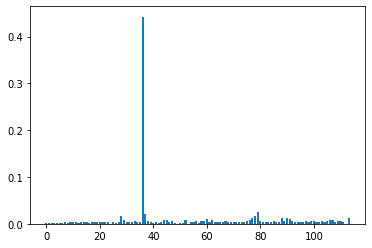

In [39]:
# summarize feature importance
importance = model_xgb.feature_importances_
for i,v in enumerate(importance):
    print(f'Feature {i}: {x_train.columns[i]}, Score: {round(v,5)}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()